In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS   = 3
EPOCHs     = 50

In [3]:
dataset        = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
    shuffle    = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 0 1 0 1 0 0 0 2 1 0 0 1 1 1 0 0 2 0 0 1 1 0 0 0 1 0 1 1 0 0 1]


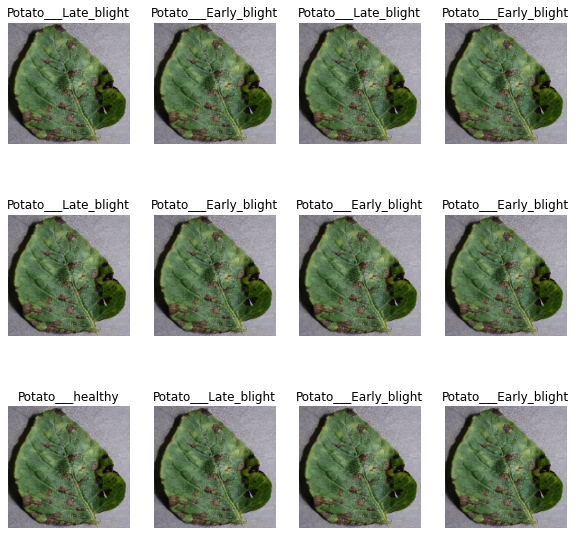

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image_batch[1].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        assert(train_split+val_split+test_split) == 1
        
        ds_size = len(ds)
        
        if shuffle:
            ds         = ds.shuffle(shuffle_size, seed=12)
            train_size = int(train_split*ds_size)
            val_size   = int(val_split*ds_size)
            train_ds   = ds.take(train_size)
            val_ds     = ds.skip(train_size).take(val_size)
            test_ds    = ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

54

In [9]:
len(val_ds)

6

In [10]:
len(test_ds)

8

In [11]:
train_ds  = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds    = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds   = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 49s 864ms/step - loss: 0.8807 - accuracy: 0.4965 - val_loss: 0.7644 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 47s 877ms/step - loss: 0.6434 - accuracy: 0.7049 - val_loss: 0.5004 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 47s 876ms/step - loss: 0.4210 - accuracy: 0.8160 - val_loss: 0.3411 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 46s 861ms/step - loss: 0.3583 - accuracy: 0.8449 - val_loss: 0.2742 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 46s 861ms/step - loss: 0.2583 - accuracy: 0.8981 - val_loss: 0.3989 - val_accuracy: 0.8073
Epoch 6/50
54/54 [==============================] - 47s 877ms/step - loss: 0.2098 - accuracy: 0.9138 - val_loss: 0.1972 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 47s 864ms/step - loss: 0.1614 - accuracy: 0.9306 - val_loss: 0.1494 - val_accuracy: 0.9531

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 192ms/step - loss: 0.0359 - accuracy: 0.9922


In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
type(history.history['loss'])

list

In [23]:
len(history.history['loss'])

50

In [24]:
history.history['loss'][:5]

[0.8807173371315002,
 0.643422544002533,
 0.42101600766181946,
 0.3582615256309509,
 0.2583099901676178]

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

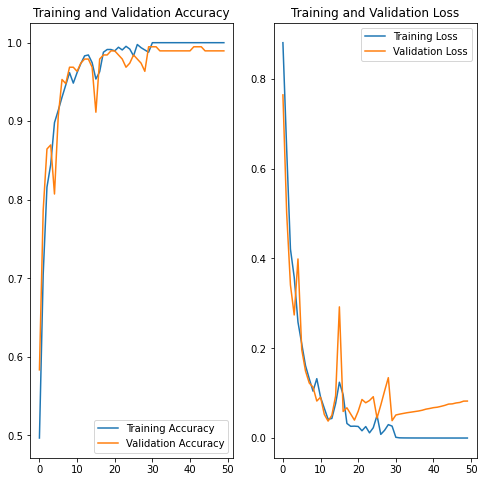

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHs), acc, label='Training Accuracy')
plt.plot(range(EPOCHs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHs), loss, label='Training Loss')
plt.plot(range(EPOCHs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 330ms/step
predicted label: Potato___Early_blight


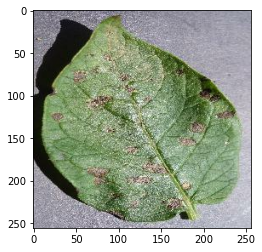

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


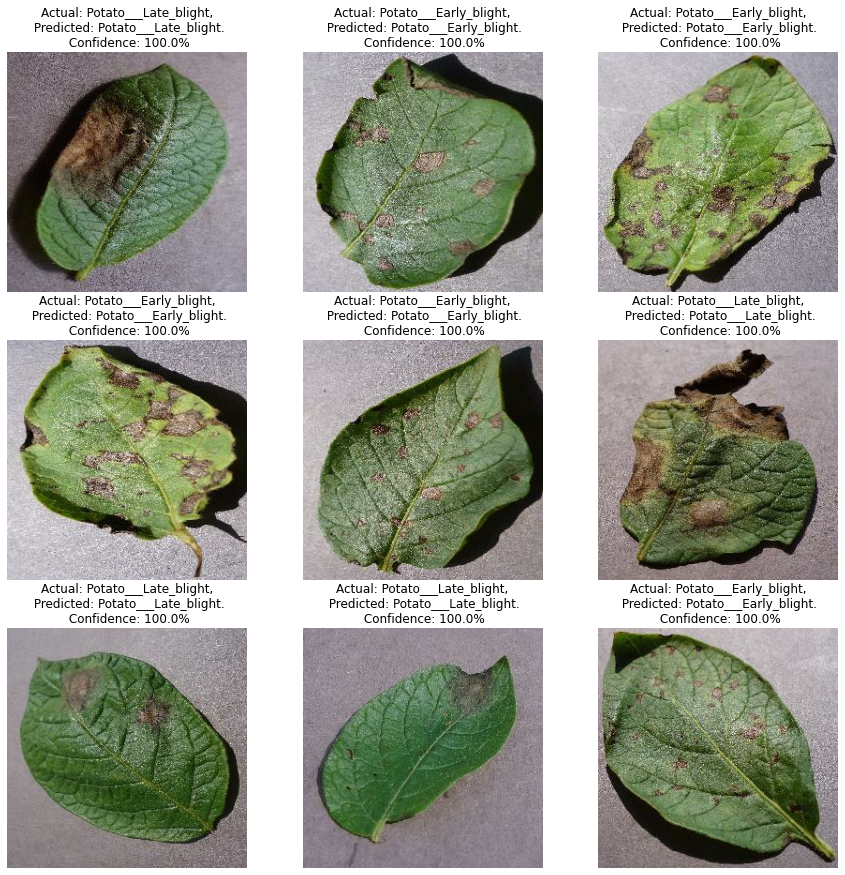

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [30]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
